<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\s'
C:\Users\apsin\AppData\Local\Temp\ipykernel_11972\679288365.py:49: SyntaxWarning: invalid escape sequence '\s'
  pretrained_model.save_weights('models\saved_models\base_model.weights.h5')
c:\Users\apsin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
Error:  0.026520467689251485
RMSE: 0.03507281665360663


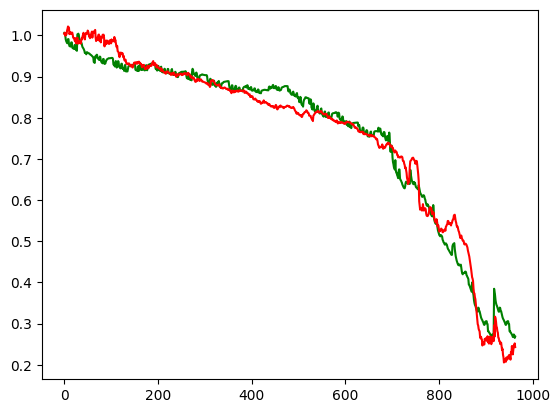

In [ ]:
# This script includes the model building for base model
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dropout, Dense, Input
from utils import dataCleaning
from utils import dataImputation
import os
from tensorflow.keras.models import load_model

class base_model_pretraining:
    def __init__(self):
        pass
    

    def pretraining_model(self,timesteps,feature_size):
        input_layer = Input(shape=(timesteps, feature_size))
        conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
        lstm1 = Bidirectional(LSTM(100, return_sequences=True))(conv1)
        dropout1 = Dropout(0.2)(lstm1)
        lstm2 = Bidirectional(LSTM(64,return_sequences=True))(dropout1)
        dropout2 = Dropout(0.2)(lstm2)
        lstm3=Bidirectional(LSTM(32))(dropout2)
        dropout3 = Dropout(0.2)(lstm3)
        dense1 = Dense(16, activation='relu')(dropout3)
        dropout4 = Dropout(0.2)(dense1)
        output_layer = Dense(1)(dropout4)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model
    
    def training(self,epochs,batch_size,feature_size,timesteps,X,Y):
        self.epochs=epochs
        self.batch_size=batch_size
        self.timesteps=timesteps
        self.feature_size=feature_size
        pretrained_model = self.pretraining_model(self.timesteps, self.feature_size)
        history = pretrained_model.fit(
            X,Y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=2
        )
        pretrained_model.save_weights('models\saved_models\base_model.weights.h5')


    def testResults(self,test_data,base_model):
        SEED = 42
        np.random.seed(SEED)
        random.seed(SEED)
        tf.random.set_seed(SEED)
        for df in test_data:
            dataset=df
            Y_actual=[]
            def preprocess_dataset(df):
                """Preprocesses dataset by normalizing and scaling features."""
                feature = df.columns.tolist()[:-1]
                source = df.copy()
                Y_actual.append(source['SOH'][timesteps:].values)
                scaler1=StandardScaler()
                exclude_features = ['SOH']
                general_features = [col for col in feature if col not in exclude_features]
                source[general_features] = scaler1.fit_transform(source[general_features])

                scaler2 = StandardScaler()
                source[['SOH']] = scaler2.fit_transform(source[['SOH']])

                return source,scaler2

            def create_dataset(X, Y, timesteps,scaler_SOH):
                """Creates time series dataset with specified timesteps."""
                Xs, Ys = [], []
                scale=[]
                for i in range(len(X) - timesteps):
                    Xs.append(X.iloc[i:i+timesteps].values)
                    Ys.append(Y.iloc[i + timesteps])
                    scale.append(scaler_SOH)
                return np.array(Xs), np.array(Ys),np.array(scale)


            timesteps = 20
            X_combined, Y_combined = [], []
            scalling=[]

            processed_data,scaler_SOH = preprocess_dataset(dataset)
            X, Y ,S= create_dataset(processed_data.iloc[:, :-1], processed_data.SOH, timesteps,scaler_SOH)
            X_combined.append(X)
            Y_combined.append(Y)
            scalling.append(S)

            X_combined = np.vstack(X_combined)
            Y_combined = np.hstack(Y_combined)
            scalling=np.hstack(scalling)
            Y_actual=np.concatenate(Y_actual)

            prediction=base_model.predict(X_combined)
            prediction=prediction.flatten()
            temp=[]
            for i in range(len(prediction)):
                a = scalling[i].inverse_transform(prediction[i].reshape(-1, 1))
                temp.append(a)

            prediction=temp
            prediction = [x.item() for x in prediction]
            error=0
            for i in range(len(Y_actual)):
                error+=abs(prediction[i]-Y_actual[i])
            print("Error: ",error/len(Y_actual))

            rmse = np.sqrt(np.mean((Y_actual - prediction) ** 2))
            print("RMSE:", rmse)

            plt.plot(Y_actual,color='g')
            plt.plot(prediction,color='r')
        plt.show()
       
    def testing(self,test_data,timesteps,feature_size):
       base_model = self.pretraining_model(timesteps,feature_size)
       base_model.build(input_shape=(None, timesteps, feature_size))
       file_path=os.path.join('saved_models','base_model.weights.h5')
       base_model.load_weights(file_path)
       self.testResults(test_data,base_model)
       
    
#Training
'''
#Get X and Y 
#Input Hyperparameters
epochs=50
timesteps=20
batch_size=32
# training_data = (Write the datasets here)
training_data="----"
training_data=dataImputation(training_data)
X,Y,scalling,Y_actual=dataCleaning(training_data)
feature_size=X.shape[2]
base_model=base_model_pretraining()
base_model.training(epochs,batch_size,feature_size,timesteps)
'''

# Testing
folder_path=os.path.join('..','Data','exclusive_test_data')
files=[os.path.join(folder_path,f) for f in os.listdir(folder_path)]
test_data=[pd.read_csv(f) for f in files]
epochs=50
timesteps=20
batch_size=32
training_data=dataImputation(test_data)
X,Y,scalling,Y_actual=dataCleaning(test_data)
feature_size=X.shape[2]
model=base_model_pretraining()
model.testing(test_data,timesteps,feature_size)




